# basic PLD

In [1]:
from astropy.io import fits as pyfits
import os
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

path='/home/jp/data/transit/c14/'
fname=os.path.join(path,'ktwo248662696-kadenza-lpd-targ.fits.gz')

def get_pixelfluxes(fname):
    pixfile=pyfits.open(fname)
    
    Xabs = pixfile[2].header['CRVAL2P'] # X position of pixel on kepler spacecraft
    Yabs = pixfile[2].header['CRVAL1P'] # Y position

    rec = pixfile[1].data #hdu.table.BinTableHDU
    dates=rec.TIME
    fluxes=rec.RAW_CNTS

    return dates,fluxes,Xabs,Yabs


t,f,x,y=get_pixelfluxes(fname)

In [2]:
hdu=pyfits.open(fname)

for i,h in enumerate(hdu):
    print(i,type(h))

(0, <class 'astropy.io.fits.hdu.image.PrimaryHDU'>)
(1, <class 'astropy.io.fits.hdu.table.BinTableHDU'>)
(2, <class 'astropy.io.fits.hdu.image.ImageHDU'>)


In [3]:
rec = hdu[1].data

In [4]:
rec.dtype

dtype((numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('RAW_CNTS', '>i4', (9, 10)), ('FLUX', '>f4', (9, 10)), ('FLUX_ERR', '>f4', (9, 10)), ('FLUX_BKG', '>f4', (9, 10)), ('FLUX_BKG_ERR', '>f4', (9, 10)), ('COSMIC_RAYS', '>f4', (9, 10)), ('QUALITY', '>i4'), ('POS_CORR1', '>f4'), ('POS_CORR2', '>f4')]))

In [5]:
t=rec.TIME
f=rec.RAW_CNTS
f.shape

(3895, 9, 10)

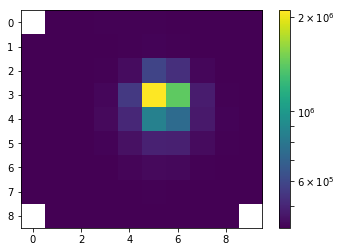

In [6]:
from matplotlib.colors import LogNorm

fmean=np.nanmean(f,axis=0)

pl.imshow(fmean,norm=LogNorm(),interpolation="none")
pl.colorbar()

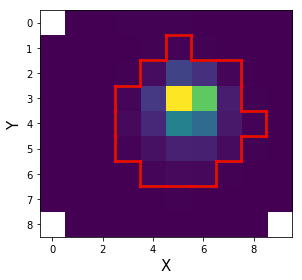

In [54]:
from scipy.ndimage import measurements
from matplotlib.colors import LogNorm
cmap='viridis'

def find_aperture(dates,fluxes,starname='',cutoff_limit=1.,showfig=None):
    #
    # This definition reads a 2D array of fluxes (over time) and creates an aperture mask which can later be used to select those pixels for inclusion in light curve
    #

    # first sum all the flux over the different times, this assumes limited movement throughout the time series
    flux = np.nansum(fluxes,axis=0)

    # define which cutoff flux to use for including pixel in mask
    cutoff = cutoff_limit*np.median(flux) # perhaps a more elaborate way to define this could be found in the future but this seems to work pretty well.

    # define the aperture based on cutoff and make it into array of 1 and 0
    aperture =  np.array([flux > cutoff]) #scipy.zeros((np.shape(flux)[0],np.shape(flux)[1]), int)
    aperture = np.array(1*aperture)
    #print aperture
    outline_all = make_aperture_outline(aperture[0]) # an outline (ONLY for figure) of what we are including if we would make no breakups

    # this cool little trick allows us to measure distinct blocks of apertures, and only select the biggest one
    lw, num = measurements.label(aperture) # this numbers the different apertures distinctly
    area = measurements.sum(aperture, lw, index=np.arange(lw.max() + 1)) # this measures the size of the apertures
    aperture = area[lw].astype(int) # this replaces the 1s by the size of the aperture
    aperture = (aperture >= np.max(aperture))*1 # remake into 0s and 1s but only keep the largest aperture

    outline = make_aperture_outline(aperture[0]) # a new outline (ONLY for figure)

    if showfig: # make aperture figure
        pl.figure('Aperture_' + str(starname))
        pl.imshow(flux,norm=LogNorm(),interpolation="none",cmap=cmap)
        pl.plot(outline_all[:, 0], outline_all[:, 1],color='green', zorder=10, lw=2.5)
        pl.plot(outline[:, 0], outline[:, 1],color='red', zorder=10, lw=2.5)#,label=str(kepmag))
        #pl.colorbar(orientation='vertical')
        pl.xlabel('X',fontsize=15)
        pl.ylabel('Y',fontsize=15)
        pl.legend()
        #pl.xlim([-1,18])
        #pl.ylim([-1,16])
        #pl.xticks([0,5,10,15])
        #pl.yticks([0,5,10,15])
        pl.tight_layout()
    return aperture


def make_aperture_outline(frame, no_combined_images=1, threshold=0.5):
  ## this is a little module that defines so called outlines to be used for plotting apertures

    thres_val = no_combined_images * threshold
    mapimg = (frame > thres_val)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0 = -0.5
    x1 = frame.shape[1]+x0
    y0 = -0.5
    y1 = frame.shape[0]+y0

    #   now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments

starname='248662696'

aperture = find_aperture(t,f,starname,cutoff_limit=1.01,showfig=True)


In [55]:
aperture[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [56]:
yi,xi=np.where(aperture[0]==1)

for j,i in zip(yi,xi):
    print(fmean[j,i])

430597.37792
447987.976637
588193.725802
528232.956354
437664.615661
437260.235173
552211.1181
2104005.94968
1417386.79949
479577.917587
442896.614121
508944.038254
860384.663928
741165.799743
473865.106033
432375.824134
430865.854429
455374.62439
492301.697304
488726.02362
443949.806162
433477.176893
442473.741977
439108.224904


In [57]:
f.shape[0]

3895

In [58]:
len(yi)

24

dict

In [59]:
pixvec={} #pixvec=np.ndarray(f.shape)

#get indices
yi,xi=np.where(aperture[0]==1)

#initialize
for l in range(len(yi)):
    pixvec[l]=[]

for l,(j,i) in enumerate(zip(yi,xi)):
    for k in range(f.shape[0]):
        '''
        k loops individual (i.e. 3895) frames
        '''
        pixvec[l].append(f[k,j,i])

In [60]:
[len(pixvec[h]) for h in pixvec]

[3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895,
 3895]

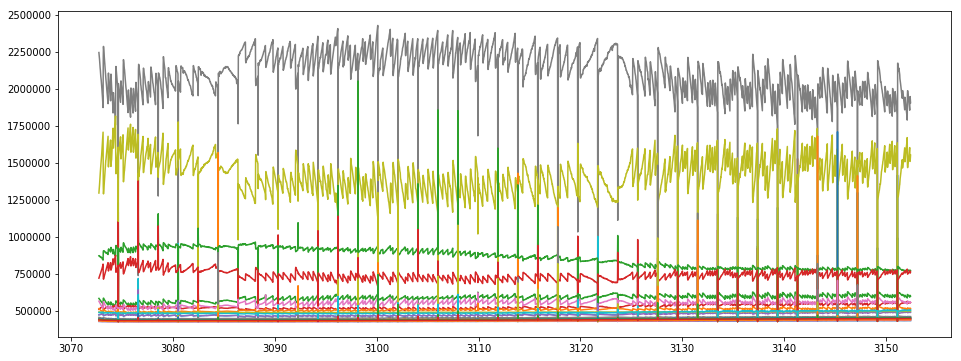

In [61]:
npix=len(pixvec)

fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(t, pixvec[n])

ndarray

## Simple Pixel Level Decorrelation (PLD)

This notebook was written by John during the workshop conducted by R. Luger as part of the Kepler conference held in June 2017.

This notebook demonstrates how to download lightcurve data from MAST using everest-pipeline and implement basic PLD technique utilizing time series from 35 individual pixels. This technique 

In [62]:
pixvec_sum=[]
for i in range(len(pixvec[0])):
    aperture_sum=0
    for j,k in enumerate(pixvec):
        #sum pixels within aperture
        aperture_sum+=pixvec[k][i]
    pixvec_sum.append(aperture_sum)
    
len(pixvec_sum)

3895

In [63]:
print(len(pixvec.values()))

24


alternatively,

In [64]:
print(len(pixvec.values()))

24


In [65]:
#pixvec_ndarray=np.reshape(pixvec.values(),(7,3895))
pixvec_sum=np.sum(pixvec.values(),axis=0)
len(pixvec_sum)

3895

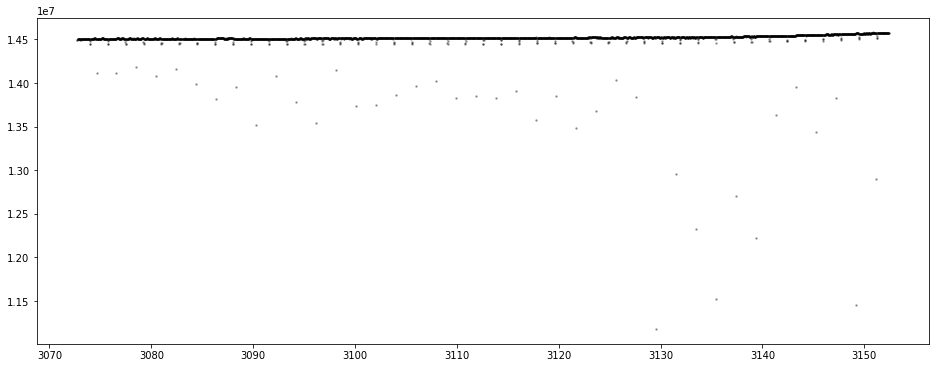

In [66]:
fig = pl.figure(figsize=(16,6))
pl.plot(t, pixvec_sum, 'k.', alpha=0.3, ms=3)

there are plenty of outliers, let's zoom in

(14294858.0, 14614858.0)

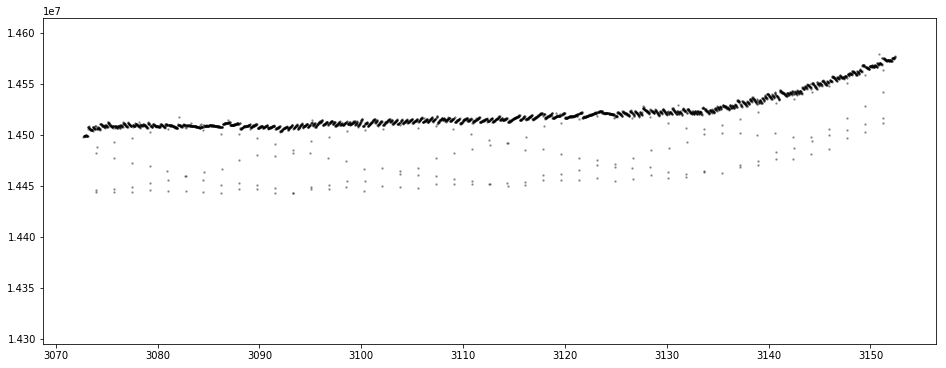

In [67]:
fig = pl.figure(figsize=(16,6))
pl.plot(t, pixvec_sum, 'k.', alpha=0.3, ms=3)
fmed=np.median(pixvec_sum)
pl.ylim(fmed-2.2e5,fmed+1e5)

Now, let's trim the data as displayed above

In [68]:
#vertical cut
cut = np.where(pixvec_sum < fmed-2.2e5)
time = np.delete(t, cut)
#flux per pixel
pixvec_ndarray=np.reshape(pixvec.values(),(len(xi),len(pixvec[0]))) #.T?
fpix = np.delete(pixvec_ndarray, cut, axis=1) #why not axis=0?

In [69]:
fpix.shape

(24, 3855)

In [70]:
time.shape==fpix[0].shape

True

without outliers

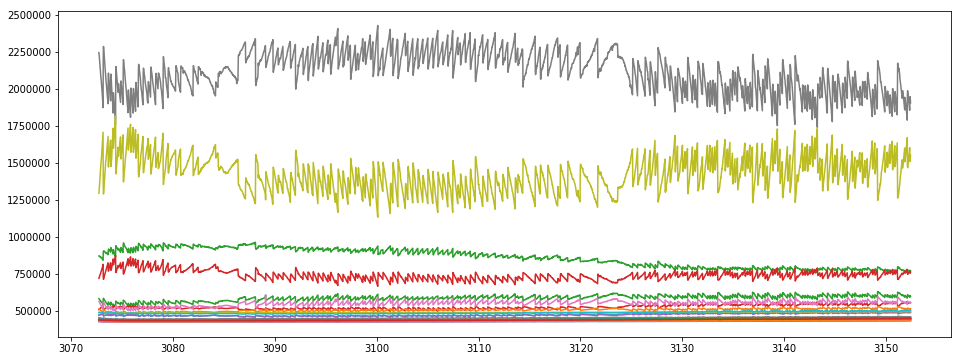

In [71]:
npix, ntime = fpix.shape

fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(time, fpix[n,:])

Similar to doing aperture photometry, sum the point-wise (at each time interval) values resembling the total flux and plot it.

In [72]:
np.sum(fpix, axis=1).shape

(24,)

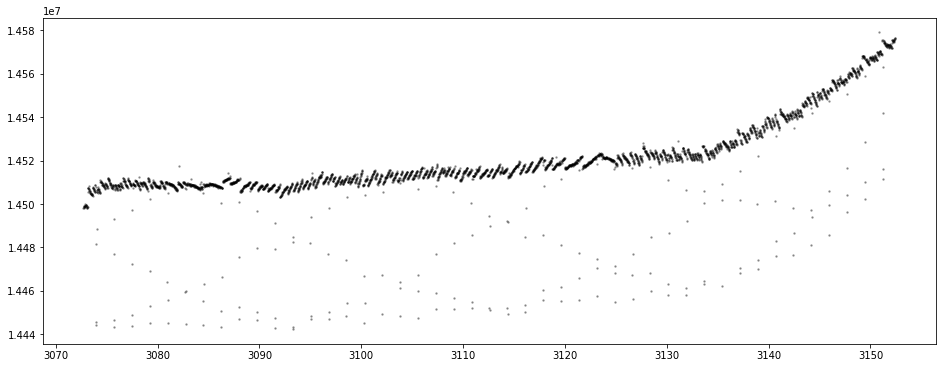

In [73]:
total_flux = np.sum(fpix, axis=0, dtype=float)#.reshape(-1,1)
fig = pl.figure(figsize=(16,6))
pl.plot(time, total_flux, 'k.', alpha=0.3, ms=3)

Normalize each pixel time series with the total flux containing the transit, variability, systematics, etc.

In [74]:
X = fpix / total_flux
X.shape

(24, 3855)

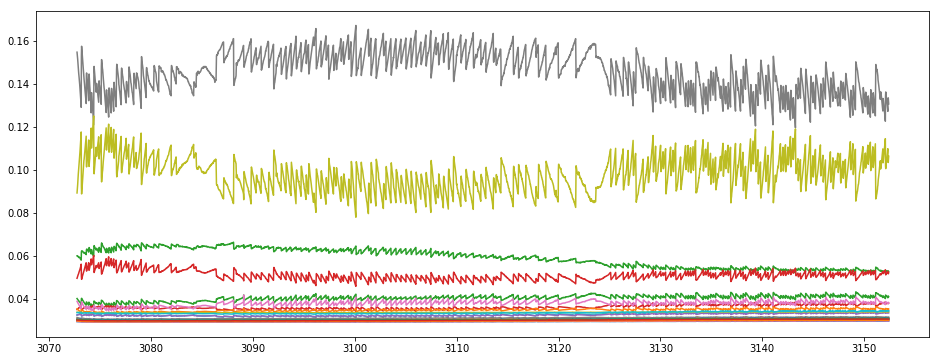

In [75]:
X = fpix / total_flux
fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(time, X[n,:])

In [76]:
m=np.dot(total_flux,X.T)
m.shape

(24,)

In [77]:
n=np.dot(X,X.T)
n.shape

(24, 24)

In [78]:
np.linalg.solve(n,m)

array([  7.69019271e+08,  -4.23433022e+07,   3.28502926e+07,
         1.26493895e+07,  -1.89772888e+07,   1.48284431e+08,
        -2.81687671e+07,   2.32984190e+07,   2.41756446e+07,
         2.26225007e+08,   1.14542003e+08,   1.99832929e+08,
         2.33825671e+07,  -9.32189153e+05,   1.75004345e+08,
        -1.66851584e+07,  -3.93240354e+08,  -1.91845815e+08,
        -3.32337451e+07,   5.21463725e+08,  -1.28043822e+09,
        -7.16617134e+07,  -7.36300271e+07,   9.78486687e+07])

Compute the weights of detrending vector given each "normalized pixel light curve," X.
Remember in linear algebra, the matrix should be square to be invertible:
\begin{align}
y=&w \cdot X \\
y\cdot X^T=&w \cdot X \cdot X^T \; (\rm{multiply \;} X^T) \\
(X \cdot X^T)^{-1}y\cdot X^T=& w \; (\rm{solve \; for \;} w)
\end{align}

In [79]:
w = np.linalg.solve(np.dot(X,X.T), np.dot(total_flux,X.T))
#w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),total_flux)
w

array([  7.69019271e+08,  -4.23433022e+07,   3.28502926e+07,
         1.26493895e+07,  -1.89772888e+07,   1.48284431e+08,
        -2.81687671e+07,   2.32984190e+07,   2.41756446e+07,
         2.26225007e+08,   1.14542003e+08,   1.99832929e+08,
         2.33825671e+07,  -9.32189153e+05,   1.75004345e+08,
        -1.66851584e+07,  -3.93240354e+08,  -1.91845815e+08,
        -3.32337451e+07,   5.21463725e+08,  -1.28043822e+09,
        -7.16617134e+07,  -7.36300271e+07,   9.78486687e+07])

In [80]:
#w = np.linalg.solve(np.dot(X,X.T), np.dot(total_flux,X.T))


w = np.dot(np.dot(np.linalg.inv(np.dot(X,X.T)),X) - alpha*np.identity(t),total_flux)
w

array([  7.69019299e+08,  -4.23432173e+07,   3.28502878e+07,
         1.26494075e+07,  -1.89773210e+07,   1.48284323e+08,
        -2.81687663e+07,   2.32984202e+07,   2.41756445e+07,
         2.26225006e+08,   1.14542001e+08,   1.99832923e+08,
         2.33825672e+07,  -9.32188711e+05,   1.75004340e+08,
        -1.66851655e+07,  -3.93240333e+08,  -1.91845811e+08,
        -3.32337571e+07,   5.21463730e+08,  -1.28043823e+09,
        -7.16617157e+07,  -7.36300053e+07,   9.78486678e+07])

Contruct a systematics model by combining the normalized pixel light curve and weights. Then detrend the total flux by subtracting the systematics model. Use std() as a measure of scatter, for comparison later.

In [81]:
model = np.dot(w,X)
detrended_flux_ls = total_flux - model
# preserve the original flux value
detrended_flux_ls += np.nanmedian(total_flux)

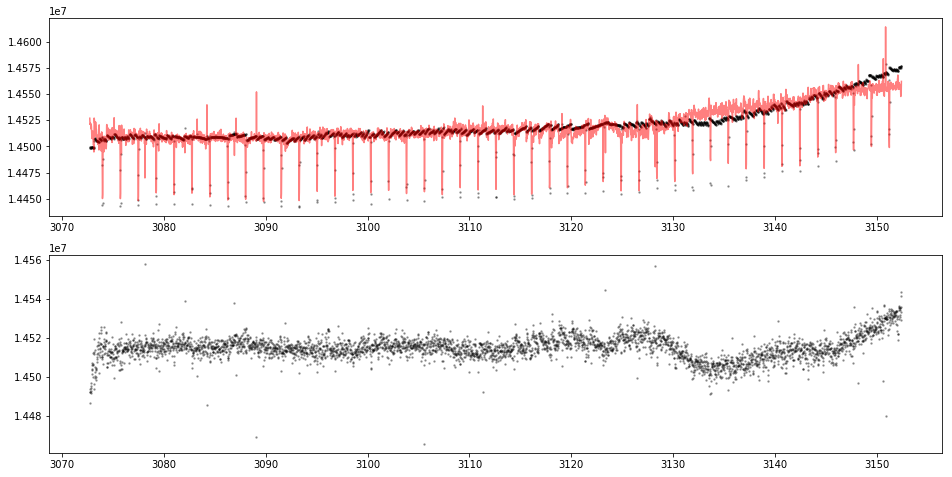

In [82]:
fig, axs = pl.subplots(2, figsize=(16,8))
#raw data
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
#model
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux_ls, 'k.', alpha=0.3, ms=3)

In [44]:
print detrended_flux_ls.std()

6269.63893939


## Modeling stellar variability

In [45]:
np.linspace(0,2,ntime).shape

(3855,)

In [46]:
X.shape

(12, 3855)

In [47]:
X = np.hstack((X.T, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))
X.shape

(3855, 62)

The design matrix, X, now has additional columns (35+50=85) besides the pixel light curves (for a 49th order polynomial!). Let's solve for the weights again.

In [48]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(total_flux,X))
model = np.dot(w,X.T)

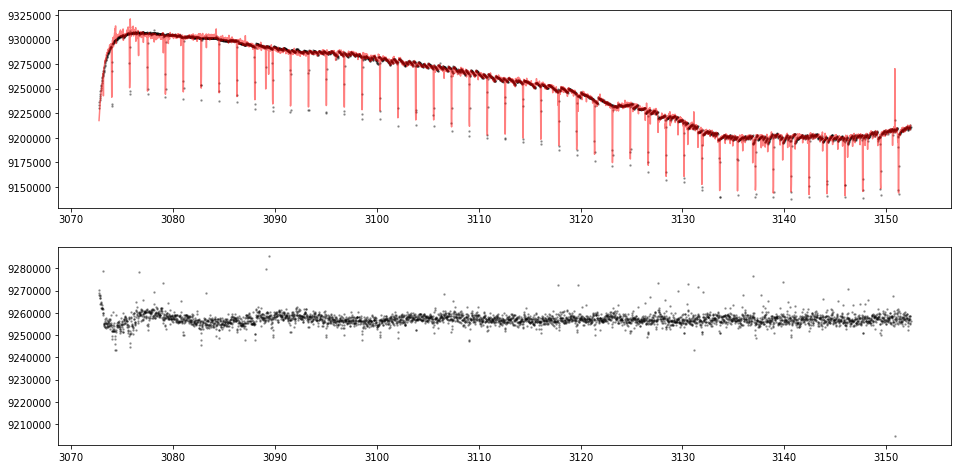

In [49]:
detrended_flux_o1 = total_flux - model
detrended_flux_o1 += np.nanmedian(total_flux)

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux_o1, 'k.', alpha=0.3, ms=3)

In [50]:
print detrended_flux_o1.std()

2694.48325065


The individual transit are even visible already!

## 2nd order PLD

In [51]:
X = np.c_[fpix.T, fpix.T**2] / total_flux.reshape(-1,1)

X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))

In [52]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T,total_flux))
#w = np.linalg.solve(np.dot(X.T.X), np.dot(X, total_flux))
model = np.dot(X,w)

In [44]:
detrended_flux_o2 = total_flux - model
detrended_flux_o2 += np.nanmedian(total_flux)
print detrended_flux_o2.std()

58527.2849581


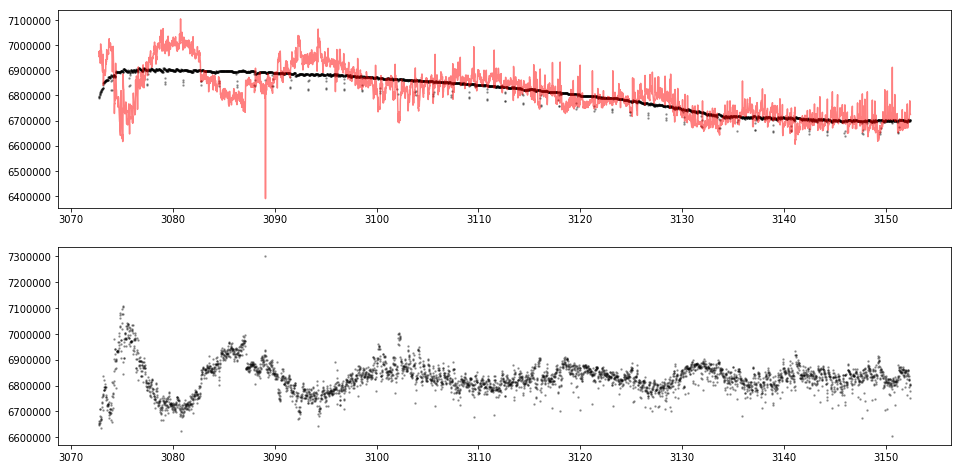

In [45]:
fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux_o2, 'k.', alpha=0.3, ms=3)

## 3rd order PLD

In [46]:
X = np.c_[fpix.T, fpix.T**3] / total_flux.reshape(-1,1)

X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))

In [47]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T,total_flux))
#w = np.linalg.solve(np.dot(X.T.X), np.dot(X, total_flux))
model = np.dot(X,w)

In [48]:
detrended_flux_o3 = total_flux - model
detrended_flux_o3 += np.nanmedian(total_flux)
print detrended_flux_o3.std()

7054.61248483


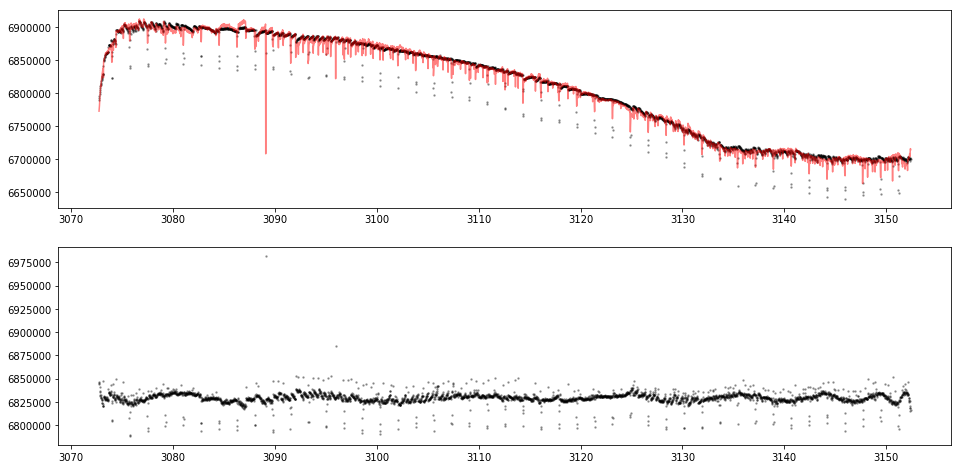

In [49]:
fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux_o3, 'k.', alpha=0.3, ms=3)

In [52]:
head='PLD detrended\ntime,aperture sum,least squares,order1,order2,order3,x,y'
data=np.c_[time,total_flux,detrended_flux_ls,detrended_flux_o1,detrended_flux_o2,detrended_flux_o3]
np.savetxt('detrended_flux_PLD_248662696.txt',data,header=head)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [51]:
data.shape

(3855, 6)